In [2]:
import cv2
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

import albumentations as A

import os
import matplotlib.pyplot as plt

In [3]:
IMG_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
MASK_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE= 32
SIZE = 256
LEARNING_RATE = 0.0003
NUM_EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True

In [4]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Contracting path (encoder)
        self.conv1 = nn.Conv2d(self.n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansive path (decoder)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Contracting path (encoder)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        x4 = F.relu(self.conv4(self.pool(x3)))
        x5 = F.relu(self.conv5(self.pool(x4)))

        # Expansive path (decoder)
        x6 = F.relu(self.upconv1(x5))
        x6 = torch.cat([x4, x6], dim=1)
        x6 = F.relu(self.conv6(x6))
        x7 = F.relu(self.upconv2(x6))
        x7 = torch.cat([x3, x7], dim=1)
        x7 = F.relu(self.conv7(x7))
        x8 = F.relu(self.upconv3(x7))
        x8 = torch.cat([x2, x8], dim=1)
        x8 = F.relu(self.conv8(x8))
        x9 = F.relu(self.upconv4(x8))
        x9 = torch.cat([x1, x9], dim=1)
        x9 = F.relu(self.conv9(x9))
        x10 = self.conv10(x9)

        return x10

In [5]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.ids = [image_file[:-4] for image_file in os.listdir(images_path) if image_file.endswith('.jpg')]
        self.size = size

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_path, self.ids[idx] + '.jpg')
        mask_path = os.path.join(self.masks_path, self.ids[idx] + '_segmentation.png')
        
        # Load image and mask
        img = cv2.imread(os.path.join(self.images_path, self.ids[idx] + '.jpg'), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(self.masks_path, self.ids[idx] + '_segmentation.png'), cv2.IMREAD_GRAYSCALE)
        
         # Convert to RGB, And convert mask to binary
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ret, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations['image']
            mask = augmentations['mask']
        
        # Convert numpy arrays to PyTorch tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        mask[mask == 255.0] = 1.0

        return img, mask

In [6]:
transform = A.Compose(
[
    A.Resize(height=SIZE, width=SIZE),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1)
])

dataset = ISICDataset(images_path=IMG_PATH,
                            masks_path=MASK_PATH, size=SIZE, transform=transform)

train_size = int(0.8 * len(dataset))
train_dataset = Subset(dataset, range(train_size))
test_dataset = Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

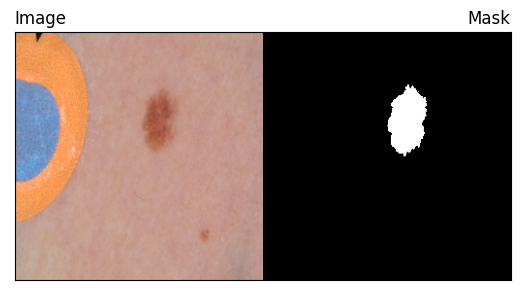

In [7]:
img, mask = test_dataset[18]
img = img.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).squeeze().numpy()
mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
mask = np.expand_dims(mask, axis=2)
mask = np.repeat(mask, 3, axis=2)
concatenated_img = np.concatenate((img, mask), axis=1)

fig, ax = plt.subplots()
ax.imshow(concatenated_img)
ax.set_title('Image', loc='left')
ax.set_title('Mask', loc='right')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

In [8]:
model = UNet(n_channels=3, n_classes=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [10]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            dice_score += (2 * (preds * y).sum()) / (preds + y).sum() + 1e-8
            
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [11]:
for epoch in range(30): 
    
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    
    if epoch % 5 == 0 and epoch != 0:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                      'epoch': epoch}
        torch.save(checkpoint, "checkpointN"+str(epoch)+"_.pth.tar")  
    
    
    for batch_idx, (images, masks) in loop:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        # Gradients to 0
        optimizer.zero_grad()

        # Forward 
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # Backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_description(f"Epoch[{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss = loss.item())


checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(checkpoint, "checkpoint_last.pth.tar")

KeyboardInterrupt: 

<b>Loading my model...</b>

In [13]:
model.load_state_dict(torch.load('/kaggle/working/checkpointN25_.pth.tar')['state_dict'])

<All keys matched successfully>

<font size=+1><b>Check accuracy of the model</b><br></font>

In [14]:
check_accuracy(test_loader, model, DEVICE)

Dice score: 0.8091263771057129



<font size=+1><b>Simple Display</b><br>
Display Original picture, True mask, Generated mask.</font>

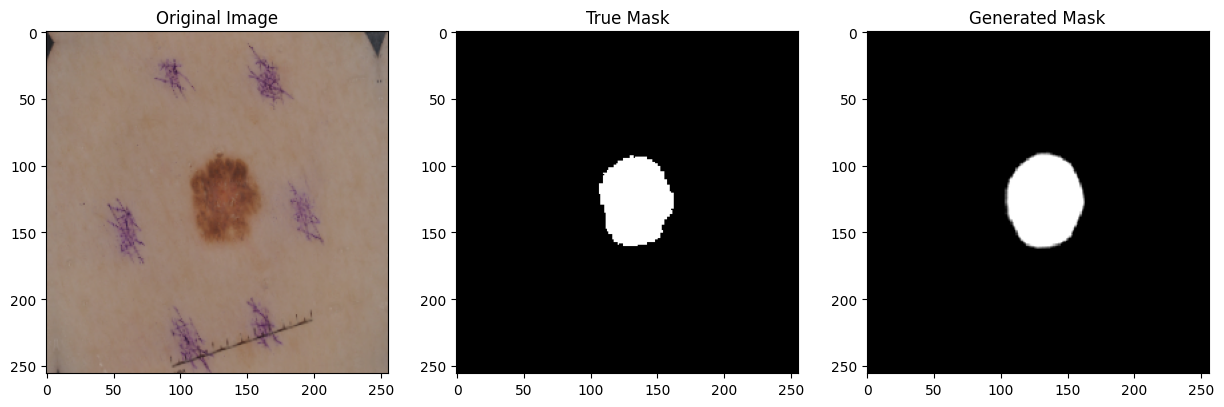

In [15]:
# Load an example image and mask
img, true_mask = test_dataset[15]
img = img.permute(1, 2, 0).numpy()
true_mask = true_mask.permute(1, 2, 0).squeeze().numpy()

# Generate a predicted mask using your trained U-net model
with torch.no_grad():
    img_tensor = torch.Tensor(img).unsqueeze(0).permute(0, 3, 1, 2).to(DEVICE)
    generated_mask = model(img_tensor).squeeze().cpu().numpy()

# Resize and stack the masks for display
true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))
true_mask_stacked = np.stack((true_mask_resized,)*3, axis=-1)

generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
generated_mask_stacked = np.stack((generated_mask_resized,)*3, axis=-1)

# Combine the image and masks into a single plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(true_mask_stacked)
ax[1].set_title('True Mask')

ax[2].imshow(generated_mask_stacked)
ax[2].set_title('Generated Mask')
plt.savefig('image_masks2.png')
plt.show()

In [16]:
torch.save(model, "skin_lease_entire_model.pth")


<font size=+1><i><b>Note:</b></i><br>
Best model was trained for 25 epochs</font>